In [ ]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pylab as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold,
)

# plt.style.use('seaborn-white')

Stroke Prediction Data. Using information about patients, predict if they are likely to have a stroke.

- Gender, marital status, smoking status, age, etc.
- Also have a "Doctor" feature added to represent the "group" within the data.

In [ ]:
# def get_prep_data():
#     data = pd.read_csv(
#         "healthcare-dataset-stroke-data.csv"
#     )
#     data["ever_married"] = (
#         data["ever_married"].replace("Yes", True).replace("No", False)
#     )
#     data["gender"] = data["gender"].astype("category")
#     data["smoking_status"] = data["smoking_status"].astype("category")
#     data["Residence_type"] = data["Residence_type"].astype("category")
#     data["work_type"] = data["work_type"].astype("category")
#     data["doctor"] = np.random.randint(0, 8, size=len(data))
#     holdout_ids = data.sample(n=500, random_state=529).index

#     train = (
#         data.loc[~data.index.isin(holdout_ids)]
#         .sample(frac=1, random_state=529)
#         .sort_values("doctor")
#         .reset_index(drop=True)
#     )
#     holdout = (
#         data.loc[data.index.isin(holdout_ids)]
#         .sample(frac=1, random_state=529)
#         .sort_values("doctor")
#         .reset_index(drop=True)
#     )

#     return train, holdout


# train, holdout = get_prep_data()

/var/folders/l5/j1q2d40112dck_z3sjyfmx9h0000gp/T/ipykernel_88081/1978881712.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["ever_married"].replace("Yes", True).replace("No", False)


In [18]:
# read CSV file
data = pd.read_csv(
    "healthcare-dataset-stroke-data.csv"
)
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
# def get_X_y(train):
#     FEATURES = [
#         "gender",
#         "age",
#         "hypertension",
#         "heart_disease",
#         "ever_married",
#         "work_type",
#         "Residence_type",
#         "avg_glucose_level",
#         "bmi",
#         "smoking_status",
#     ]

#     GROUPS = "doctor"

#     TARGET = "stroke"

#     X = train[FEATURES]
#     y = train[TARGET]
#     groups = train[GROUPS]
#     return X, y, groups

In [ ]:
def get_prep_data(csv_path="healthcare-dataset-stroke-data.csv",
                  holdout_size=500,
                  random_state=529):
    # 1) load and basic cleanup
    data = pd.read_csv(csv_path)
    # parse "N/A" in bmi as NaN
    data['bmi'] = pd.to_numeric(data['bmi'], errors='coerce')
    # map ever_married to 0/1
    data['ever_married'] = data['ever_married'].map({'Yes': 1, 'No': 0})
    # add a random 'doctor' group
    # data['doctor'] = np.random.RandomState(random_state).randint(0, 8, size=len(data))

    # 2) split out holdout
    holdout_ids = data.sample(n=holdout_size, random_state=random_state).index
    train_df = data.drop(holdout_ids).reset_index(drop=True)
    holdout_df = data.loc[holdout_ids].reset_index(drop=True)

    # 3) separate X/y
    target_col = 'stroke'
    drop_cols = ['id', target_col]
    X_train = train_df.drop(columns=drop_cols)
    y_train = train_df[target_col].values
    X_hold = holdout_df.drop(columns=drop_cols)
    y_hold = holdout_df[target_col].values

    # 4) define which columns are numeric vs. categorical
    numeric_features = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 
                        'heart_disease', 'ever_married']
    categorical_features = ['gender', 'work_type', 'Residence_type', 'smoking_status']

    # 5) build preprocessing pipelines
    numeric_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('num', numeric_pipe, numeric_features),
        ('cat', categorical_pipe, categorical_features),
    ], sparse_threshold=0)

    # 6) fit on train, transform both
    X_train_enc = preprocessor.fit_transform(X_train)
    X_hold_enc  = preprocessor.transform(X_hold)

    return X_train_enc, y_train, X_hold_enc, y_hold, preprocessor

In [23]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = get_prep_data()
# clf = SVC(
#     kernel="rbf",
#     C=10,
#     probability=True,
#     random_state=529,
#     class_weight="balanced",
# )
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    random_state=529,
    class_weight="balanced",
)
clf.fit(X_train_enc, y_train)

# Predict on training set
pred = clf.predict(X_train_enc)
pred_prob = clf.predict_proba(X_train_enc)[:, 1]

acc_score = accuracy_score(y_train, pred)
auc_score = roc_auc_score(y_train, pred_prob)

print(f'The score on the training set is accuracy: {acc_score:0.4f} and AUC of {auc_score:0.4f}')

The score on the training set is accuracy: 0.9963 and AUC of 0.9998


Model can predict 99% accuracy? Nope!

Check the performance on the test set.

In [24]:
# compute performance on test set
pred_test = clf.predict(X_test_enc)
pred_prob_test = clf.predict_proba(X_test_enc)[:, 1]
acc_score_test = accuracy_score(y_test, pred_test)
auc_score_test = roc_auc_score(y_test, pred_prob_test)
print(f'The score on the test set is accuracy: {acc_score_test:0.4f} and AUC of {auc_score_test:0.4f}')

The score on the test set is accuracy: 0.9480 and AUC of 0.7324


In [19]:
acc_score = accuracy_score(y_test, np.zeros_like(y_test))
auc_score = roc_auc_score(y_test, np.zeros_like(y_test))
print(
    f"Our baseline on the holdout set is {acc_score:0.4f} and AUC is {auc_score:0.4f}"
)

Our baseline on the holdout set is 0.9480 and AUC is 0.5000


In [46]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10, cmap_cv=plt.cm.coolwarm, cmap_data=plt.cm.Paired):    
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

<Axes: title={'center': 'StratifiedKFold'}, xlabel='Sample index', ylabel='CV iteration'>

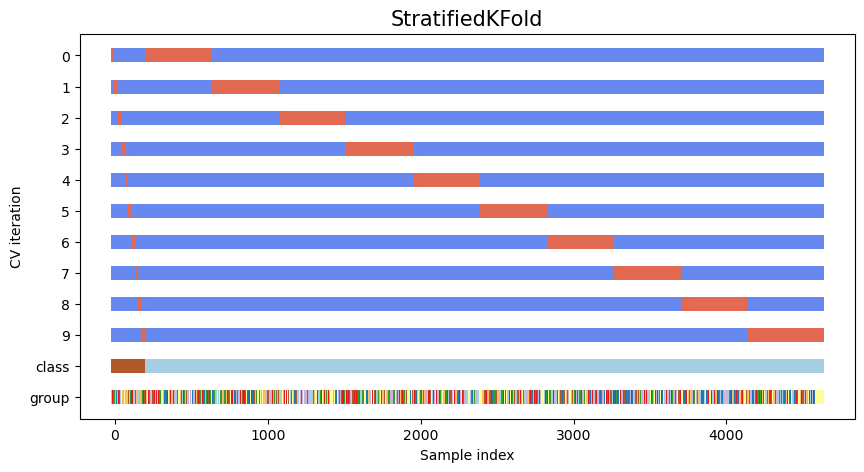

In [47]:
# cv = KFold(n_splits=5, shuffle=False)
cv = StratifiedKFold(n_splits=10, shuffle=False)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_cv_indices(cv, X_train_enc, y_train, X_train_enc[:, 6], ax, n_splits=10)

(array([4387.,  223.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

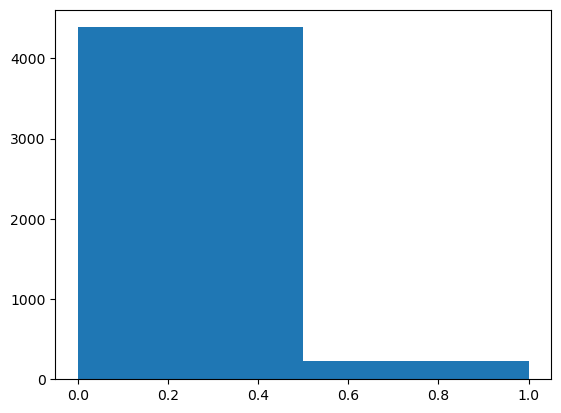

In [40]:
plt.hist(y_train, bins=2)

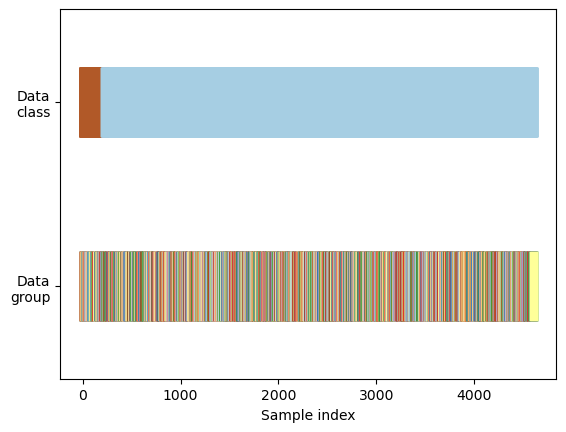

In [38]:
def visualize_groups(classes, groups, name, cmap_data=plt.cm.Paired):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )
    
    
visualize_groups(y_train, X_train_enc[:,6], "no groups")